In [1]:
import os
import sys
sys.path.insert(0, os.getcwd())
import pandas as pd
import argparse
import time
from utils.data_frame_parser import DataFrameParser
from utils.numpytupledataset import NumpyTupleDataset
from utils.smile_to_graph import GGNNPreprocessor

## change data_loader_mol.py

In [10]:
import json
from utils.data_loader_mol import load_mol, MolDataset, get_transform_fn

mols = load_mol('data/qm9_kekulized.npz')


Loading file data/qm9_kekulized.npz


In [11]:
with open('data/valid_idx_qm9.json') as f:
    test_idx = json.load(f)

test_idx = test_idx['valid_idxs']
test_idx = [int(i) for i in test_idx]
train_idx = [i for i in range(133885) if i not in test_idx]
print(f'Number of training mols: {len(train_idx)} | Number of test mols: {len(test_idx)}')
train_mols = [mols[i] for i in train_idx]
test_mols = [mols[i] for i in test_idx]

train_dataset = MolDataset(train_mols, get_transform_fn('QM9')) #"qm9" / "zinc250k"
test_dataset = MolDataset(test_mols, get_transform_fn("QM9"))

Number of training mols: 120803 | Number of test mols: 13082


In [15]:
train_dataset[25000]

(tensor([[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]),
 tensor([[0., 3., 0., 0., 0., 0., 0., 0., 0.],
         [3., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 2., 0.],
         [0., 0., 1., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 1., 2., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 2., 0., 0., 1., 0.],
         [0., 0., 2., 0., 0., 0., 1., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.]]))

In [ ]:
start_time = time()
test_mols = 

## reimplement the get_transform_fn()
### QM9

In [2]:
import pickle
import networkx as nx
with open('data/qm9_train_nx.pkl', 'rb') as f:
    train_mols_nx_1 = pickle.load(f)

mol_nx = train_mols_nx_1[25000]
# see node attributes
print(mol_nx.nodes(data=True))
# see edge attributes
print(mol_nx.edges(data=True))
# extract adjacency matrix with edge attributes
adj = nx.to_numpy_matrix(mol_nx, weight='order')
adj

[(0, {'label': 'C'}), (1, {'label': 'C'}), (2, {'label': 'C'}), (3, {'label': 'O'}), (4, {'label': 'C'}), (5, {'label': 'N'}), (6, {'label': 'C'}), (7, {'label': 'C'}), (8, {'label': 'C'})]
[(0, 1, {'label': 1}), (1, 2, {'label': 1}), (1, 6, {'label': 1}), (2, 3, {'label': 1}), (2, 7, {'label': 1}), (3, 4, {'label': 1}), (4, 5, {'label': 1}), (4, 6, {'label': 1}), (7, 8, {'label': 3})]


matrix([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]])

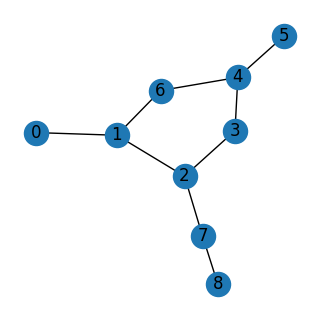

In [3]:
# draw the graph
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
nx.draw(mol_nx, with_labels=True)
plt.show()

In [4]:
import numpy as np
import torch
def extract_adjacency_matrix(graph, pad_virtual_nodes=True):
    max_nodes = 9 if pad_virtual_nodes else len(graph.nodes)
    adjacency_matrix = np.zeros((max_nodes, max_nodes))

    for i, j, data in graph.edges(data=True):
        # Retrieve the label of the edge
        label = data.get('label', 0)  # Default to 0 if no label is found
        adjacency_matrix[i, j] = label
        adjacency_matrix[j, i] = label  # Since the graph is undirected

    return torch.from_numpy(adjacency_matrix).float()

# order difference with the original function
def extract_node_feature_matrix_qm9(graph, pad_virtual_nodes=True):
    one_hot_mapping = {'C': [1, 0, 0, 0], 'N': [0, 1, 0, 0], 'O': [0, 0, 1, 0], 'F': [0, 0, 0, 1]}
    max_nodes = 9 if pad_virtual_nodes else len(graph.nodes)

    # Initialize a matrix of zeros
    feature_matrix = np.zeros((max_nodes, 4))

    for node, data in graph.nodes(data=True):
        # Retrieve the label and convert to one-hot encoding
        label = data.get('label', 'C')  # Default to 'C' if no label is found
        one_hot = one_hot_mapping.get(label, one_hot_mapping['C'])  # Default to 'C' encoding if label is not found
        feature_matrix[node] = one_hot

    return torch.from_numpy(feature_matrix).float()

def extract_edge_features(graph):
    one_hot_mapping = {1: [1, 0, 0], 2: [0, 1, 0], 3: [0, 0, 1]}
    edge_features = []

    for _, _, data in graph.edges(data=True):
        # Retrieve the label of the edge
        label = data.get('label', 1)  # Default to 1 if no label is found
        one_hot = one_hot_mapping.get(label, one_hot_mapping[1])  # Default to label 1 encoding if label is not found
        edge_features.append(one_hot)

    return torch.tensor(edge_features, dtype=torch.float)

In [42]:
mol_nx = train_mols_nx_1[3]
print(extract_adjacency_matrix(mol_nx, 1))
print(extract_node_feature_matrix_qm9(mol_nx, 1))
print(extract_edge_features(mol_nx))

tensor([[0., 3., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0., 0., 1.]])


## CAN
It seems we don't need to pad virtual nodes or edges for CAN

In [47]:
with open("data/qm9_train_rings.pkl", "rb") as f:
    qm9_train_rings = pickle.load(f)
mol_nx = qm9_train_rings[25000]
mol_ring = qm9_train_rings[25000]
print(mol_ring)

[(1, 2, 3, 4, 6)]


In [48]:
# lift the molecular graph to a cellular complex 
# and extract upper and lower adjacency matrices for the 1-skeleton
from toponetx.classes.cell_complex import CellComplex

cell_complex = CellComplex(mol_nx)
cell_complex.add_cells_from(mol_ring, rank = 2)
print(cell_complex)
print(cell_complex.down_laplacian_matrix(rank=1, signed=False).todense())
# print(cell_complex.incidence_matrix(rank=1, signed=False).todense())
# print(cell_complex.incidence_matrix(rank=2, signed=False).todense())
print(cell_complex.up_laplacian_matrix(rank=1, signed=False).todense())

Cell Complex with 5 nodes, 5 edges and 2 2-cells 
[[2. 1. 1. 0. 0.]
 [1. 2. 0. 0. 1.]
 [1. 0. 2. 1. 0.]
 [0. 0. 1. 2. 1.]
 [0. 1. 0. 1. 2.]]
[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]]


In [36]:
from itertools import zip_longest
mol_rings_1 = [1,2,3,4,6]
list(zip_longest(mol_rings_1, mol_rings_1[1:] + [mol_rings_1[0]]))
print({cell.elements: celli for celli, cell in enumerate(cell_complex.cells)})

{(1, 2, 3, 4, 6): 0}


In [29]:
sorted(mol_nx.nodes())
sorted([sorted(e) for e in mol_nx.edges()])
for celli, cell in enumerate(cell_complex.cells):
    print(celli)
    for edge in cell.boundary:
        print(edge)

0
(1, 2)
(2, 3)
(3, 4)
(4, 6)
(6, 1)


In [23]:
import scipy as sp

# calculate edge adjacency matrix for the 1-skeleton of the graph

def incidence_matrix(graph, signed=False, index=False, rank=1):
    if rank == 0:
        A = sp.sparse.lil_matrix((0, len(graph.nodes())))
        if index:
            node_index = {node: i for i, node in enumerate(sorted(graph.nodes()))}
            if signed:
                return {}, node_index, A.asformat("csr")
            else:
                return {}, node_index, abs(A.asformat("csr"))
        else:
            if signed:
                return A.asformat("csr")
            else:
                return abs(A.asformat("csr"))
    elif rank == 1:
        nodelist = sorted(graph.nodes())  # always output boundary matrix in dictionary order
        edgelist = sorted([sorted(e) for e in graph.edges()])
        A = sp.sparse.lil_matrix((len(nodelist), len(edgelist)))
        node_index = {node: i for i, node in enumerate(nodelist)}
        for ei, e in enumerate(edgelist):
            (u, v) = e[:2]
            ui = node_index[u]
            vi = node_index[v]
            A[ui, ei] = -1
            A[vi, ei] = 1

        if index:
            edge_index = {tuple(sorted(edge)): i for i, edge in enumerate(edgelist)}
            if signed:
                return node_index, edge_index, A.asformat("csr")
            else:
                return node_index, edge_index, abs(A.asformat("csr"))
        else:
            if signed:
                return A.asformat("csr")
            else:
                return abs(A.asformat("csr"))
    elif rank == 2:
        edgelist = sorted([sorted(e) for e in graph.edges()])

        A = sp.sparse.lil_matrix((len(edgelist), len(self.cells)))

        edge_index = {
            tuple(sorted(edge)): i for i, edge in enumerate(edgelist)
        }  # orient edges
        for celli, cell in enumerate(self.cells):
            edge_visiting_dic = {}  # this dictionary is cell dependent
            # mainly used to handle the cell complex non-regular case
            for edge in cell.boundary:
                ei = edge_index[tuple(sorted(edge))]
                if ei not in edge_visiting_dic:
                    if edge in edge_index:
                        edge_visiting_dic[ei] = 1
                    else:
                        edge_visiting_dic[ei] = -1
                else:
                    if edge in edge_index:
                        edge_visiting_dic[ei] = edge_visiting_dic[ei] + 1
                    else:
                        edge_visiting_dic[ei] = edge_visiting_dic[ei] - 1

                A[ei, celli] = edge_visiting_dic[
                    ei
                ]  # this will update everytime we visit this edge for non-regular cell complexes
                # the regular case can be handled more efficiently :
                # if edge in edge_index:
                #    A[ei, celli] = 1
                # else:
                #    A[ei, celli] = -1
        if index:
            cell_index = {c.elements: i for i, c in enumerate(self.cells)}
            if signed:
                return edge_index, cell_index, A.asformat("csr")
            else:
                return edge_index, cell_index, abs(A.asformat("csr"))
        else:
            if signed:
                return A.asformat("csr")
            else:
                return abs(A.asformat("csr"))
    else:
        raise ValueError(f"Only dimensions 0, 1 and 2 are supported, got {rank}.")
    
def down_laplacian_matrix(graph, signed=False, index=False):
    #suppose 0 < rank <= self.dim
    row, column, B = incidence_matrix(graph, index=True)
    L_down = B.transpose() @ B
    if signed:
        L_down = abs(L_down)
    if index:
        return row, L_down
    else:
        return L_down
    
def up_laplacian_matrix(graph, signed=False, index=False):
    # suppose rank < self.dim

    
print(down_laplacian_matrix(train_mols_nx_1[100], signed=False, index=False).todense())


[[2. 1. 0. 0.]
 [1. 2. 1. 0.]
 [0. 1. 2. 1.]
 [0. 0. 1. 2.]]


In [31]:
import pickle
import networkx as nx
with open('data/qm9_train_nx.pkl', 'rb') as f:
    train_mols_nx_1 = pickle.load(f)

mol_nx = train_mols_nx_1[25000]
# see node attributes
print(mol_nx.nodes(data=True))
# see edge attributes
print(mol_nx.edges(data=True))
# extract adjacency matrix with edge attributes
adj = nx.to_numpy_matrix(mol_nx, weight='order')
adj

[(0, {'label': 'C'}), (1, {'label': 'C'}), (2, {'label': 'C'}), (3, {'label': 'O'}), (4, {'label': 'C'}), (5, {'label': 'N'}), (6, {'label': 'C'}), (7, {'label': 'C'}), (8, {'label': 'C'})]
[(0, 1, {'label': 1}), (1, 2, {'label': 1}), (1, 6, {'label': 1}), (2, 3, {'label': 1}), (2, 7, {'label': 1}), (3, 4, {'label': 1}), (4, 5, {'label': 1}), (4, 6, {'label': 1}), (7, 8, {'label': 3})]


matrix([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]])